In [6]:
import torch
from torch_geometric.loader import DataLoader  # Use PyTorch Geometric's DataLoader
from torchvision import datasets, transforms    
import os
from _04_mnist_digits.graph_dataset import GraphDataset

# Define a transform to convert the images to tensors
transform = transforms.ToTensor()

# Download and load the MNIST dataset
train_dataset = datasets.MNIST(root='/data', train=True, transform=transform)
test_dataset = datasets.MNIST(root='/data', train=False, transform=transform)

In [7]:
from shared.models.GNNClassifier import GNNClassifier
from shared.training import train_classifier
from torch_geometric.nn import EdgeCNN
import torch_geometric.nn as nn
from torch_geometric.nn import summary

In [8]:

images_train = train_dataset.data
labels_train = train_dataset.targets
images_test = test_dataset.data 
labels_test = test_dataset.targets

print(images_train.shape)
print(images_test.shape)
print(labels_train.shape)
print(labels_test.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
torch.Size([60000])
torch.Size([10000])


In [9]:
images = torch.cat((images_train, images_test), dim=0)
labels = torch.cat((labels_train, labels_test), dim=0)
print(images.shape)
print(labels.shape)

torch.Size([70000, 28, 28])
torch.Size([70000])


In [10]:
saved_dataset_path = '_04_mnist_digits/data/graph_dataset_with_centroids_and_px_counts.pt'

if os.path.exists(saved_dataset_path):
    print(f"Loading existing dataset from {saved_dataset_path}")
    dataset = torch.load(saved_dataset_path, weights_only=False)
    print(f"Loaded dataset with {len(dataset)} graphs")
else:
    print(f"Creating new dataset with {len(images)} images...")
    dataset = GraphDataset(images, labels, use_weighted_edges=True)
    print(f"Saving dataset to {saved_dataset_path}")
    torch.save(dataset, saved_dataset_path)
    print("Dataset saved!")

Loading existing dataset from _04_mnist_digits/data/graph_dataset_with_centroids_and_px_counts.pt
Loaded dataset with 70000 graphs


In [11]:
from torch_geometric.data import Data, Dataset

class GraphDatasetWithCentroids(Dataset):
    def __init__(self, Xs, centroids, edge_indices=None, edge_weights=None, labels=None):
        super().__init__()
        self.Xs = Xs
        self.centroids = centroids
        self.edge_indices = edge_indices
        self.edge_weights = edge_weights
        self.labels = labels
    
    def len(self):
        return len(self.Xs)
    
    def get(self, idx):
        return Data(x=torch.cat((self.Xs[idx].unsqueeze(-1), self.centroids[idx]), dim=1), # (Nnodes, 1) + (Nnodes, 2)
        edge_index=self.edge_indices[idx].T, # (2, Nedges)
        edge_weight=self.edge_weights[idx],
        y=self.labels[idx])

new_dataset = GraphDatasetWithCentroids(dataset.Xs, dataset.centroids, dataset.edge_indices, dataset.edge_weights, dataset.labels)


In [12]:
dataset = new_dataset

In [13]:
example_x = dataset[0].x
if example_x.dim() == 2:
    num_features = example_x.shape[1]  # Set the number of features
else:
    num_features = 1

num_classes = len(set(dataset.labels.tolist()))  # Set the number of classes

datasets = {}
loaders = {}

for split, dataset in zip(["train", "val", "test"], torch.utils.data.random_split(dataset, (0.7, 0.15, 0.15))):
    datasets[split] = dataset
    loaders[split] = DataLoader(dataset, batch_size=(32 if split == "train" else len(dataset)), shuffle=(split == "train"))

In [14]:
print(datasets["train"][0])

Data(x=[21, 3], edge_index=[2, 68], y=7, edge_weight=[68])


In [18]:
class Classifier(GNNClassifier):
    def __init__(self, in_channels, num_classes, num_layers, hidden_channels, **kwargs):
        super().__init__(num_node_features=in_channels,
                        num_classes=num_classes,
                        hidden_ch=hidden_channels,)
        self.edgecnn = EdgeCNN(in_channels=in_channels,
                               num_layers=num_layers,
                               hidden_channels=hidden_channels,
                               )

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = self.edgecnn(x, edge_index, edge_weight=edge_weight)

        # Use PyTorch Geometric's global_max_pool which handles batching correctly
        if batch is None:
            # If no batch info, assume single graph
            x = torch.max(x, dim=0, keepdim=True).values
        else:
            # Proper batched global pooling
            x = nn.global_max_pool(x, batch)
        
        x = self.mlp(x)
        return x
    
    def get_model_inputs_from_batch(self, batch):
        return 

model = Classifier(in_channels=num_features,
                num_classes=10,
                num_layers=3,
                hidden_channels=128,)

model.get_model_inputs_from_batch = lambda batch: (batch.x, batch.edge_index, batch.batch)


loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for batch in loaders["train"]:
    print(batch)
    print([x.shape for x in model.get_model_inputs_from_batch(batch)])
    print(summary(model, *model.get_model_inputs_from_batch(batch)))
    break

print(model)

DataBatch(x=[837, 3], edge_index=[2, 2599], y=[32], edge_weight=[2599], batch=[837], ptr=[33])
[torch.Size([837, 3]), torch.Size([2, 2599]), torch.Size([837])]
+----------------------------+----------------------------+----------------+----------+
| Layer                      | Input Shape                | Output Shape   | #Param   |
|----------------------------+----------------------------+----------------+----------|
| Classifier                 | [837, 3], [2, 2599], [837] | [32, 10]       | 184,202  |
| ├─(convolutions)ModuleList | --                         | --             | 66,688   |
| │    └─(0)GraphConv        | --                         | --             | 896      |
| │    └─(1)GraphConv        | --                         | --             | 32,896   |
| │    └─(2)GraphConv        | --                         | --             | 32,896   |
| ├─(mlp)Sequential          | [32, 128]                  | [32, 10]       | 1,290    |
| │    └─(0)Linear           | [32, 128]        

In [19]:
overall_train_acc, overall_val_acc = train_classifier(N_epochs=25,
                                                    model=model,
                                                    train_dataloader=loaders["train"],
                                                    val_dataloader=loaders["val"],
                                                    loss=loss,
                                                    optimizer=optimizer,
                                                    )

Epoch    T Loss  T Acc  V Loss  V Acc

1/25     1.202   0.583   0.888   0.694
2/25     0.746   0.749   0.697   0.773
3/25     0.623   0.794   0.606   0.798
4/25     0.547   0.818   0.524   0.827
5/25     0.502   0.834   0.504   0.838
6/25     0.462   0.848   0.474   0.850
7/25     0.429   0.858   0.475   0.847
8/25     0.402   0.867   0.435   0.859
9/25     0.378   0.875   0.446   0.859
10/25    0.364   0.880   0.538   0.826
11/25    0.347   0.885   0.426   0.866
12/25    0.332   0.890   0.418   0.866
13/25    0.318   0.896   0.458   0.857
14/25    0.308   0.896   0.436   0.864
15/25    0.300   0.899   0.433   0.862
16/25    0.289   0.904   0.391   0.874
17/25    0.283   0.904   0.392   0.877
18/25    0.269   0.909   0.399   0.873
19/25    0.258   0.913   0.411   0.873
20/25    0.255   0.913   0.401   0.878
21/25    0.245   0.917   0.392   0.879
22/25    0.239   0.920   0.396   0.878
23/25    0.229   0.923   0.404   0.876
24/25    0.227   0.922   0.388   0.888
25/25    0.217   0.926   

In [20]:
torch.save(model.state_dict(), "_04_mnist_digits/models/EdgeCNN_unweighted_with_centroids.pt")

In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

for batch in loaders["test"]:
    y_true = batch.y
    y_pred = model(*model.get_model_inputs_from_batch(batch)).argmax(dim=1)
    print(classification_report(y_true, y_pred, digits=4, target_names=[str(i) for i in range(10)]))

    mat = confusion_matrix(y_true, y_pred)

              precision    recall  f1-score   support

           0     0.9594    0.9594    0.9594      1035
           1     0.9193    0.9608    0.9396      1174
           2     0.8503    0.9224    0.8849      1096
           3     0.8829    0.8028    0.8409      1014
           4     0.8129    0.9311    0.8680      1031
           5     0.8758    0.8641    0.8699       971
           6     0.9225    0.9281    0.9253      1001
           7     0.9241    0.8923    0.9079      1105
           8     0.8239    0.7836    0.8033      1063
           9     0.8837    0.7901    0.8343      1010

    accuracy                         0.8849     10500
   macro avg     0.8855    0.8835    0.8834     10500
weighted avg     0.8858    0.8849    0.8842     10500



Text(0.5, 58.7222222222222, 'Predicted')

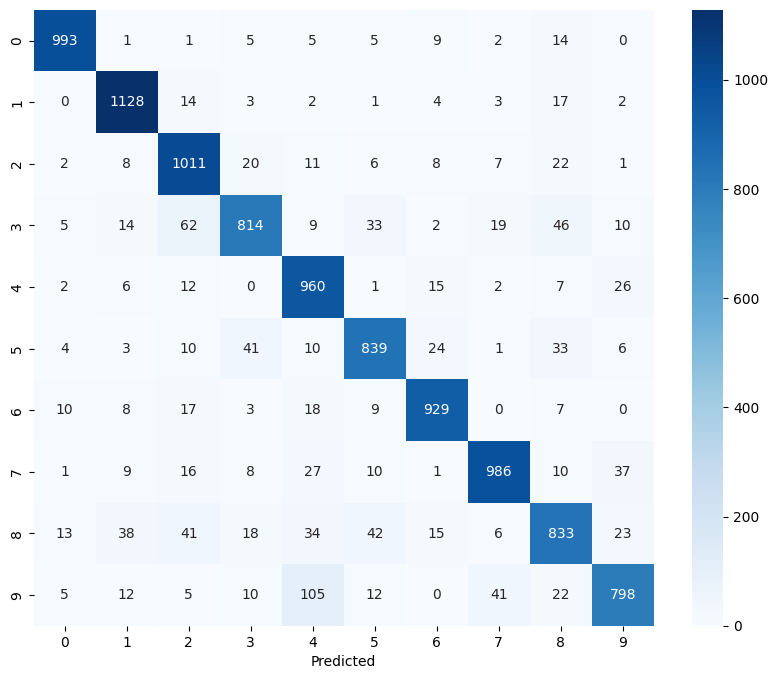

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted')

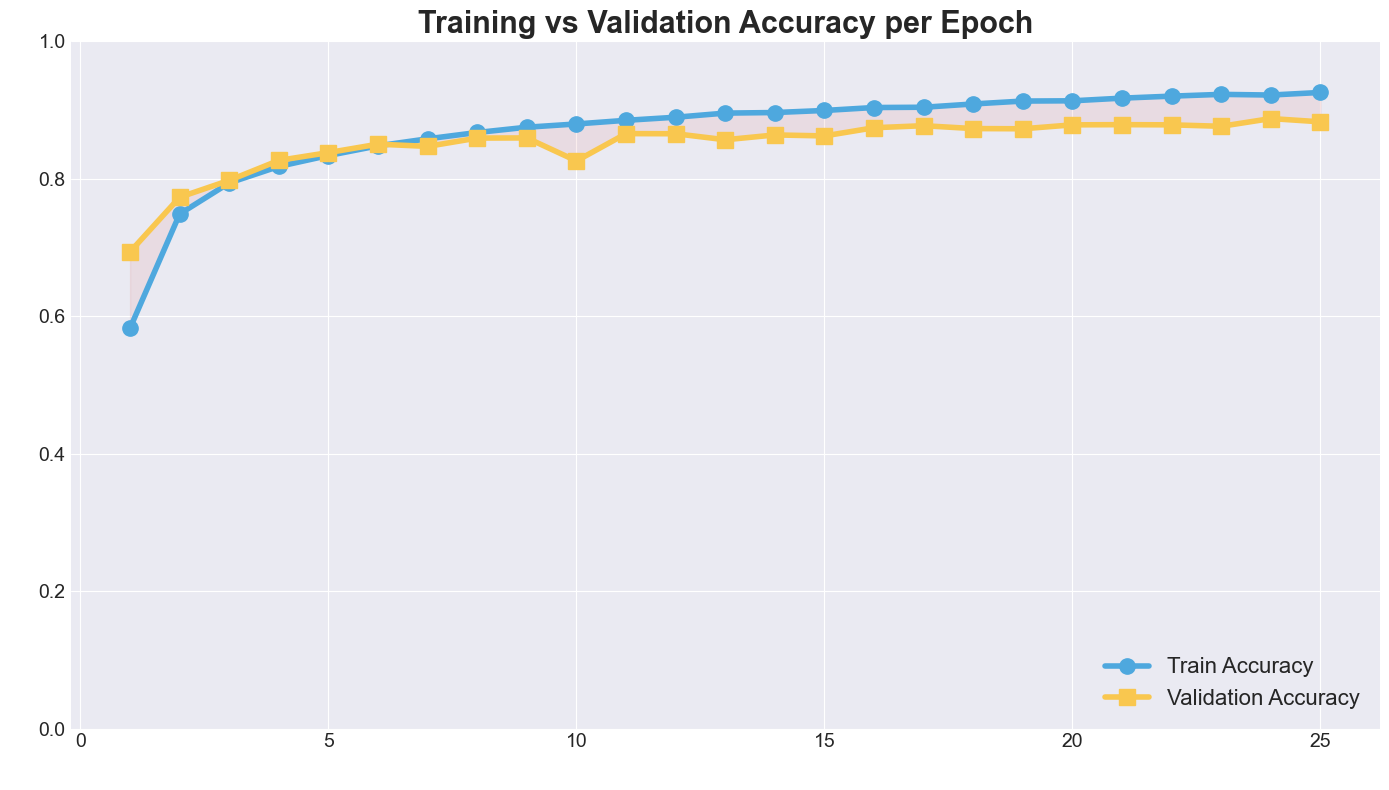

In [23]:
plt.figure(figsize=(14, 8))
plt.style.use('seaborn-v0_8-darkgrid')

epochs = range(1, len(overall_train_acc) + 1)

plt.plot(epochs, overall_train_acc, label='Train Accuracy', linewidth=4, marker='o', color='#4ea8de', markersize=11)
plt.plot(epochs, overall_val_acc, label='Validation Accuracy', linewidth=4, marker='s', color='#f9c74f', markersize=11)

# Highlight the area between curves for clarity
plt.fill_between(epochs, overall_train_acc, overall_val_acc, color="#e08888", alpha=0.15)

plt.xlabel('Epoch', fontsize=18, color='white', weight='bold')
plt.ylabel('Accuracy', fontsize=18, color='white', weight='bold')
plt.title('Training vs Validation Accuracy per Epoch', fontsize=22, weight='bold')
plt.legend(loc='lower right', fontsize=16)
plt.ylim(0, 1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

# Graph analysis to see compression

In [27]:
for batch in loaders["val"]:
    Nnodes = batch.x.shape[0] # total number of nodes in the batch
    Nedges = batch.edge_index.shape[1] # total number of edges in the batch
    avg_nodes = Nnodes / len(batch)
    avg_edges = Nedges / len(batch)
    avg_degree = Nedges / Nnodes

    print(f"Batch: {batch}, \nAvg Nodes: {avg_nodes:.2f}, \nAvg Edges: {avg_edges:.2f}, \nAvg Degree: {avg_degree:.2f}")

Batch: DataBatch(x=[280103, 3], edge_index=[2, 888215], y=[10500], edge_weight=[888215], batch=[280103], ptr=[10501]), 
Avg Nodes: 26.68, 
Avg Edges: 84.59, 
Avg Degree: 3.17


In [32]:
print(img_dim := images_train[0].shape[1] * images_train[0].shape[0])

784


In [33]:
print(compression_ratio := (avg_nodes * num_features) / img_dim)

0.10207835276967929


--> This technique requires only one tenth of space while providing good accuracy.
It also allows to only use one "RGB" channel for grayscale images, while resnet requires all three channels

In [34]:
print(full_compression_ratio := (avg_nodes * num_features + 2 * avg_edges) / img_dim)

0.3178740281827016


20% of the data can be saved by not storing edges and using kNN linking on the fly (at train startup, since the burden of computing edges on the fly each time outweighs the benefit of memory saving)

These results match quite well with: https://www.researchgate.net/publication/380292085_Graph_Convolutional_Networks_for_Image_Classification_Comparing_Approaches_for_Building_Graphs_from_Images

[Rodrigues, J. and Carbonera, J. (2024). Graph Convolutional Networks for Image Classification: Comparing Approaches for Building Graphs from Images. In Proceedings of the 26th International Conference on Enterprise Information Systems - Volume 1: ICEIS; ISBN 978-989-758-692-7; ISSN 2184-4992, SciTePress, pages 437-446. DOI: 10.5220/0012263200003690]